In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from spikeship import spikeship
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch, os
from tqdm import tqdm
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, SpectralEmbedding, TSNE

/gs/home/grimaldiav/.conda/envs_ppc/ppc-spikeship/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/mnt/pns/home/grimaldiav/Documents/SpikeShip/spikeship/spikeship.py:254: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(int32(int32, int32))


In [3]:
def tensor2spikeship(rp_tensor):
    N_epochs, N_neurons, N_timesteps = rp_tensor.shape
    #epochs, neurons, times = np.where(rp_tensor>0)
    spike_times = np.array([])
    ii_spike_times = np.zeros([N_epochs, N_neurons, 2])
    nb_previous_timestamps = 0
    last_previous_timestamp = 0
    for e in tqdm(range(N_epochs)):
        neurons, times = np.where(rp_tensor[e,:,:]>0)
        for n in np.unique(neurons):
            indices = np.where(neurons==n)[0]
            ii_spike_times[e,n,:] = [indices[0], indices[-1]+1] + np.ones([2])*nb_previous_timestamps
            spike_times = np.hstack([spike_times,times[indices]]) if spike_times.shape[0]>0 else times[indices]
        nb_previous_timestamps += len(times)
        #last_previous_timestamp += times[-1]
    return spike_times, ii_spike_times

def plot_raster(raster, trial_nb = 0, colored=False, title = 'raster plot'):

    subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)

    xticks, yticks = 6, 16
    spikelength=.9
    colors = ['grey', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
 '#7f7f7f', '#bcbd22', '#17becf']
    figsize = (12, 1.61803)
    linewidths=1.0
    
    if colored:
        N_kernels, N_trials, N_neurons, N_timesteps = raster.shape
    else:
        N_trials, N_neurons, N_timesteps = raster.shape

    fig, ax = plt.subplots(1, 1, figsize=figsize, subplotpars=subplotpars)
    if colored:

        for i in range(0, N_neurons):
            for sm in range(N_kernels):
                ax.eventplot(np.where(raster[sm, trial_nb, i, :] > 0)[0],
                    colors=colors[sm], lineoffsets=1.*i+spikelength/2,
                    linelengths=spikelength, linewidths=linewidths)
    else:
        for i in range(0, N_neurons):
            ax.eventplot(np.where(raster[trial_nb, i, :] > 0)[0],
                colors=colors[0], lineoffsets=1.*i+spikelength/2,
                linelengths=spikelength, linewidths=linewidths)

    ax.set_ylabel('address')
    ax.set_xlabel('Time (a. u.)')
    ax.set_xlim(0, N_timesteps)
    ax.set_ylim(0, N_neurons)

    ax.set_yticks(np.arange(0, N_neurons, 1)+.5)
    ax.set_yticklabels('')#np.linspace(1, N_neurons, 9, endpoint=True).astype(int))
    for side in ['top', 'right']: ax.spines[side].set_visible(False)

    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(N_timesteps/4))
    ax.set_xticks(np.linspace(1, N_timesteps, xticks, endpoint=True))
    ax.set_xticklabels(np.linspace(1, N_timesteps, xticks, endpoint=True).astype(int))
    ax.set_title(title)

    ax.grid(visible=True, axis='y', linestyle='-', lw=.5)
    #ax.grid(visible=True, axis='x', which='both', linestyle='-', lw=.1)
    return fig, ax

def plot_SM(SMs, N_show = 5, cmap='plasma', colors=None, aspect=None, figsize = (12, 1.61803)):
    subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)

    N_SMs, N_pre, N_delays = SMs.shape

    fig, axs = plt.subplots(1, N_show, figsize=figsize, subplotpars=subplotpars)
    for i_SM in range(N_show):
        ax = axs[i_SM]
        ax.set_axisbelow(True)
        ax.pcolormesh(SMs[i_SM, :, :].flip(1), cmap=cmap, vmin=SMs.min(), vmax=SMs.max())
        #ax.imshow(self.SMs[:, i_SM, :], cmap=cmap, vmin=0, vmax=1, interpolation='none')
        ax.set_xlim(0, N_delays)
        ax.set_xlabel('Delay')
        t = ax.text(.805*N_delays, .95*N_pre, f'#{i_SM+1}', color='k' if colors is None else colors[i_SM])
        t.set_bbox(dict(facecolor='white', edgecolor='white'))
        if not aspect is None: ax.set_aspect(aspect)

        ax.set_ylim(0, N_pre)
        ax.set_yticks(np.arange(0, N_pre, 1)+.5)
        if i_SM>0:
            ax.set_yticklabels([])
        else:
            ax.set_yticklabels(np.arange(0, N_pre, 1)+1)

        for side in ['top', 'right']: ax.spines[side].set_visible(False)
        ax.set_xticks([1, N_delays//3, (N_delays*2)//3])
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(N_delays//4))

    axs[0].set_ylabel('@ Neuron')
    return fig, axs

def gaussian_kernel(n_steps, mu, std):
    x = torch.arange(n_steps)
    return torch.exp(-(x-mu)**2/(2*std**2))/(std*torch.sqrt(torch.Tensor([2*torch.pi])))

In [4]:
class SM_World:
    def __init__(self, opt, add_coef = None):
        # initialization of the parameters + drawing of the kernels
        # here one of the kernels is a combination of the 2 first ones with parameter add_coef ([0,1])
        self.opt: Params = opt
        if add_coef is not None:
            self.kernels = torch.zeros(self.opt.N_kernels+1, self.opt.N_pre, self.opt.N_delays)
        else:
            self.kernels = torch.zeros(self.opt.N_kernels, self.opt.N_pre, self.opt.N_delays)

        for k in range(self.kernels.shape[0]):
            nb_spikes = int(torch.normal(torch.Tensor([self.opt.avg_N_spikes]), torch.Tensor([self.opt.std_N_spikes])).abs())
            addr, delay, precision = (torch.randint(self.opt.N_pre, [nb_spikes]), torch.randint(self.opt.N_delays, [nb_spikes]), torch.normal(torch.ones([nb_spikes])*self.opt.avg_precision, torch.ones([nb_spikes])*self.opt.std_precision).abs())
            for s in range(nb_spikes):
                self.kernels[k, addr[s], :] += gaussian_kernel(self.opt.N_delays, delay[s], 1/precision[s])
            self.kernels[self.kernels>1] = 1
            
        if add_coef is not None:
            assert len(add_coef)==self.opt.N_kernels
            assert add_coef.sum()==1
            add_coef = torch.hstack([add_coef,torch.zeros(1)])
            self.kernels[-1, :, :] = torch.matmul(self.kernels.T,add_coef).T
        self.add_coef = add_coef
    
    def draw_input_one_sm(self, N_trials = 1, do_channels = False):
        #spontaneous_activity = torch.bernoulli(torch.ones([N_trials, self.opt.N_pre, self.opt.N_timesteps])*self.opt.p_spontaneous)
        labels = torch.randint(self.kernels.shape[0], [N_trials])
        max_proba = torch.ones([N_trials, self.opt.N_pre, self.opt.N_timesteps])
        input_rp = torch.zeros([N_trials, self.opt.N_pre, self.opt.N_timesteps])
        
        if self.add_coef is not None:
            output_labels = self.add_coef.repeat(N_trials,1)
        else:
            output_labels = labels
        for k in range(self.kernels.shape[0]):
            indices = labels == k
            input_rp[indices,:,:] = torch.bernoulli(torch.min(self.kernels[k,:,:].unsqueeze(0).repeat(indices.sum(),1,1), max_proba[indices,:,:]))
            if self.add_coef is not None:
                if k<(self.kernels.shape[0]-1):
                    output_labels[indices,:] = k
                else:
                    output_labels[indices,-1] = k
        return input_rp, output_labels

In [5]:
class world_params:
    N_pre = 100 # number of neurons in the RP
    N_delays = 51 # number of timesteps in the SM (must be an odd number for convolutions)
    N_kernels = 3 # number of SM used for RP generation

    p_input = .1 # global probability of having a spike in the timebins of the RP as input
    sm_ratio = .5 # probability of a spike as input to belong to the SM
    p_spontaneous =  p_input*(1-sm_ratio)
    p_spike_in_motif = p_input*sm_ratio # probability of having a spike in the timebins of the SM

    avg_N_spikes = p_spike_in_motif*N_delays*N_pre
    std_N_spikes = 1

    N_timesteps =  N_delays # number of timesteps in the RP

    avg_precision = 5 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    std_precision = 1 # variance for the precision

    seed = 4815162342 # seed

## Model with 2 motifs and a combination of the 2

In [6]:
N_trials = 1000
add_coef = torch.Tensor([.2,.7,.1])

In [7]:
opt = world_params()
world = SM_World(opt, add_coef = add_coef)
input_rp, labels = world.draw_input_one_sm(N_trials = N_trials, do_channels = True)

/tmp/ipykernel_3288548/3118222254.py:22: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch_1681837271882/work/aten/src/ATen/native/TensorShape.cpp:3281.)
  self.kernels[-1, :, :] = torch.matmul(self.kernels.T,add_coef).T


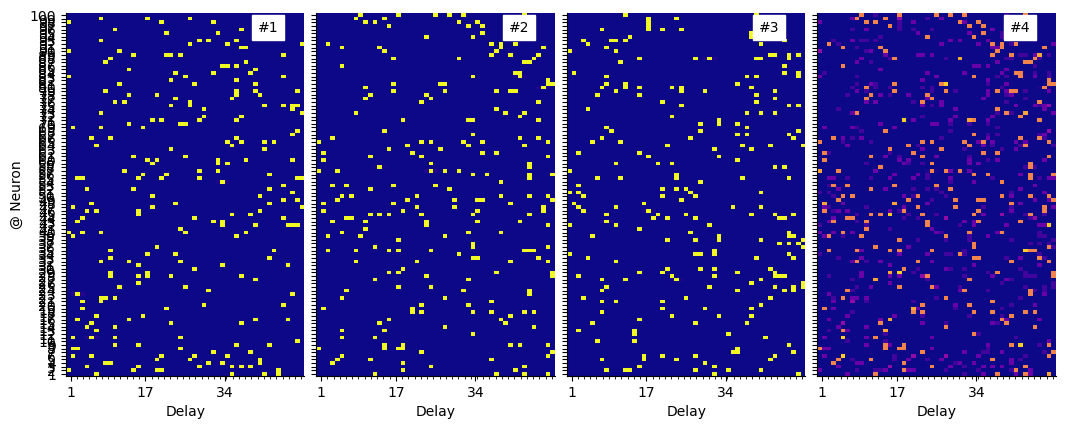

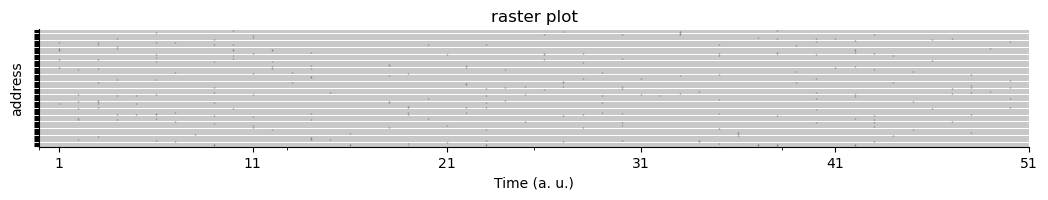

In [8]:
plot_SM(world.kernels, N_show = world.kernels.shape[0], figsize = (12, 5));
plot_raster(input_rp, colored=False);

### Format the ouput for SpikeShip

In [9]:
stacked_input = torch.Tensor([])
stacked_labels = torch.Tensor([])

values = [0, 0.2, 0.4, 0.6, 0.8, 1]
N_trials = 20

for add_coef_1 in tqdm(values):
    for add_coef_2 in values:
        for add_coef_3 in values:
            sum_coef = add_coef_1+add_coef_2+add_coef_3
            if sum_coef>0:
                world.add_coef = torch.tensor([add_coef_1, add_coef_2, add_coef_3, 0])/sum_coef
                world.kernels[-1, :, :] = torch.matmul(world.kernels.T,world.add_coef).T
                input_rp, output_labels = world.draw_input_one_sm(N_trials = N_trials)
                #print(input_rp.shape, output_labels.shape, stacked_input.shape, stacked_labels.shape)
                if stacked_input.shape[0]>0:
                    stacked_input = torch.vstack([stacked_input,input_rp])
                    stacked_labels = torch.vstack([stacked_labels,output_labels])
                else:
                    stacked_input = input_rp
                    stacked_labels = output_labels

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:21<00:00,  3.57s/it]


### Remove trials with neurons and no spike (gives np.nan in S_dist) - TODO: find a better generative model

In [10]:
if (stacked_input.sum(dim=(1,2))<1).sum()>0:
    print(f'{(stacked_input.sum(dim=(1,2))<1).sum()} trials with no spike for at least one neuron')
    spike_ind = (stacked_input.sum(dim=(1,2))>=1)
    input_rp, labels = stacked_input[spike_ind,:,:], stacked_labels[spike_ind]
else:
    input_rp, labels = stacked_input, stacked_labels

In [11]:
spike_times, ii_spike_times = tensor2spikeship(input_rp)
ii_spike_times = ii_spike_times.astype('int32')
labels = labels.numpy()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4300/4300 [01:52<00:00, 38.35it/s]


In [12]:
print(input_rp.shape, ii_spike_times.shape)

torch.Size([4300, 100, 51]) (4300, 100, 2)


In [13]:
%%time
S_dist = spikeship.distances(spike_times, ii_spike_times)

CPU times: user 27min 53s, sys: 101 ms, total: 27min 53s
Wall time: 10.8 s


In [14]:
if np.isnan(S_dist).sum():
    print(f'{np.isnan(S_dist).sum()/(S_dist.shape[0]**2)*100}% of nan values')

In [15]:
print(np.unique(S_dist))

[0.00000000e+00 2.12765957e-03 2.24719101e-03 ... 1.14566867e+01
 1.14574900e+01 1.14682129e+01]


In [16]:
print(labels.shape)

(4300, 4)


In [17]:
si = np.argsort(labels[:,-1])
print(si.shape)

(4300,)


### Dissimilarity matrix

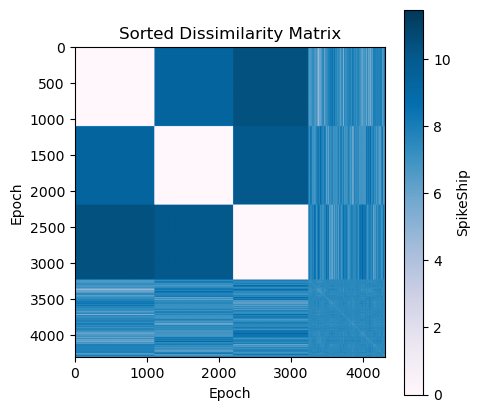

In [18]:
fig, axs = plt.subplots(figsize=(5,5), facecolor='w')
axs.set_xlabel("Epoch"); axs.set_ylabel("Epoch");
#axs.set_xticklabels(labels[si][[0,200,400,600,800,1000]]); #axs.set_ylabel("Epoch");
im = axs.imshow(S_dist[:,si][si], cmap='PuBu')
axs.set_title("Sorted Dissimilarity Matrix")
cbar = plt.colorbar(im, ax=axs)
cbar.set_label("SpikeShip", fontsize=10)

## Linear dimensionnality reduction methods
### Principal component analysis

In [26]:
number_of_components = len(world.add_coef)-1
colors = ['r', 'g', 'b']

In [27]:
pca = PCA(n_components=number_of_components)
pca.fit(S_dist)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.54780697 0.44405731 0.00722539]
[11930.21648752 10741.23110108  1370.14042501]


In [32]:
pca.components_.shape

(3, 4300)

In [33]:
labels[indices,:3]

array([[0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       ...,
       [0.33333334, 0.33333334, 0.33333334],
       [0.33333334, 0.33333334, 0.33333334],
       [0.33333334, 0.33333334, 0.33333334]], dtype=float32)

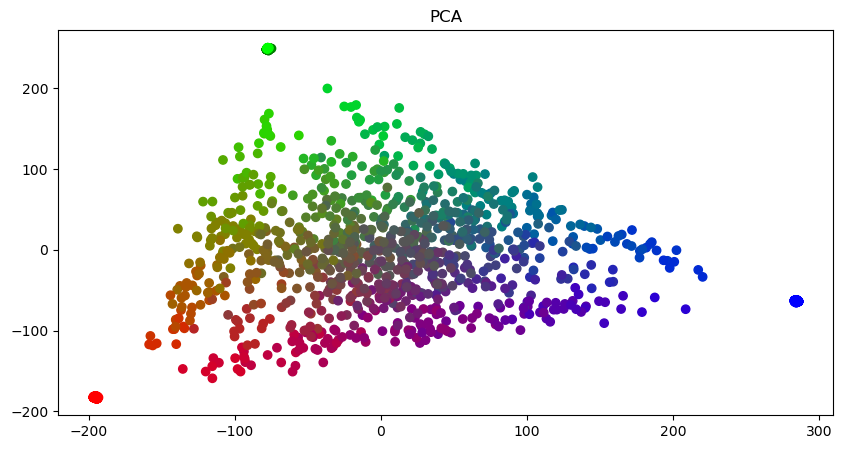

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
for l in np.unique(labels[:,-1]):
    indices = labels[:,-1]==l

    if l<np.unique(labels[:,-1])[-1]:
        ax.scatter(pca.fit_transform(S_dist)[indices,0], pca.fit_transform(S_dist)[indices,1], facecolors=colors[int(l)])#, label=f'{np.round(l*100)}%')
    else:
        ax.scatter(pca.fit_transform(S_dist)[indices,0], pca.fit_transform(S_dist)[indices,1], facecolors=labels[indices,:3])
#ax.legend(loc='upper right')
ax.set_title('PCA');

In [30]:
print(indices)

[False False  True ...  True False False]


### Singular value decomposition 

In [23]:
svd = TruncatedSVD(n_components=number_of_components, n_iter=51, random_state=42)
svd.fit(S_dist)
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())
print(svd.singular_values_)

[0.00707091 0.54669461 0.44395507]
0.9977205861228708
[29932.49719778 11920.0016881  10740.15304603]


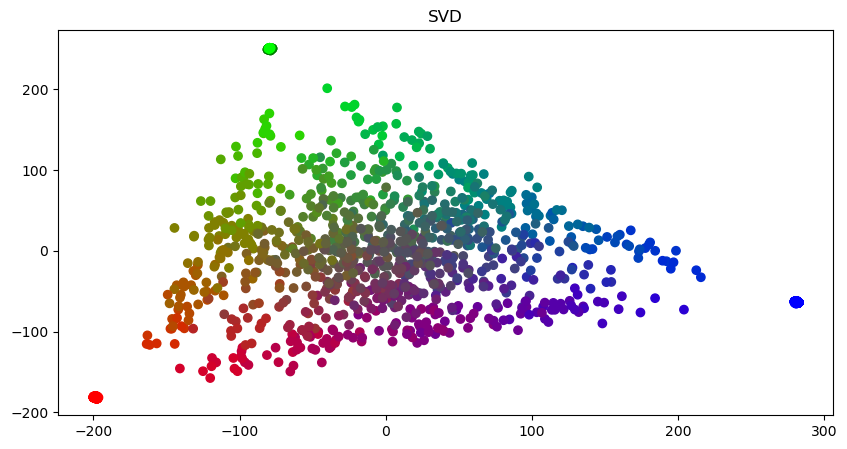

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
for l in np.unique(labels[:,-1]):
    indices = labels[:,-1]==l
    if l<np.unique(labels[:,-1])[-1]:
        ax.scatter(svd.fit_transform(S_dist)[indices,1], svd.fit_transform(S_dist)[indices,2], facecolors=colors[int(l)])
    else:
        ax.scatter(svd.fit_transform(S_dist)[indices,1], svd.fit_transform(S_dist)[indices,2], facecolors=labels[indices,:3])
ax.set_title('SVD');

## Non-linear dimensionnality reduction methods
### Multidimensionnal scaling

In [25]:
mds_embedding = MDS(n_components=number_of_components, dissimilarity='precomputed').fit_transform(S_dist)# metric=True, normalized_stress='auto')

/gs/home/grimaldiav/.conda/envs_ppc/ppc-spikeship/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
for l in np.unique(labels[:,-1]):
    indices = labels[:,-1]==l
    if l<np.unique(labels[:,-1])[-1]:
        ax.scatter(mds_embedding[indices,2], mds_embedding[indices,1], facecolors=colors[int(l)])
    else:
        ax.scatter(mds_embedding[indices,2], mds_embedding[indices,1], facecolors=labels[indices,:3])
ax.set_title('MDS');

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
for l in np.unique(labels[:,-1]):
    indices = labels[:,-1]==l
    if l<np.unique(labels[:,-1])[-1]:
        ax.scatter(mds_embedding[indices,0], mds_embedding[indices,1], mds_embedding[indices,2], facecolors=colors[int(l)])
    else:
        ax.scatter(mds_embedding[indices,0], mds_embedding[indices,1], mds_embedding[indices,2], facecolors=labels[indices,:3])
ax.set_title('MDS');
ax.view_init(60, 60)

### Laplacian eigenmaps

In [ ]:
print(number_of_components)

In [ ]:
s_embedding = SpectralEmbedding(n_components=number_of_components, affinity='precomputed')#.fit_transform(S_dist)
s_embedding.fit(S_dist)

In [ ]:
#input_flatten = input_rp.flatten(start_dim=1)
fig, ax = plt.subplots(figsize=(10,5))
for l in np.unique(labels[:,-1]):
    indices = labels[:,-1]==l
    if l<np.unique(labels[:,-1])[-1]:
        ax.scatter(s_embedding.fit_transform(S_dist)[indices,0], s_embedding.fit_transform(S_dist)[indices,1], facecolors=colors[int(l)])
    else:
        ax.scatter(s_embedding.fit_transform(S_dist)[indices,0], s_embedding.fit_transform(S_dist)[indices,1], facecolors=labels[indices,:3])
ax.set_title('Laplacian Eigenmaps');

### 2D t-SNE emb

In [ ]:
def get_2d_tsne_embedding(diss, perplexity=70., n_components=2):
    return TSNE(metric='precomputed', n_components=n_components, random_state=0, perplexity=perplexity, init='random').fit_transform(diss)

In [ ]:
S_emb = get_2d_tsne_embedding(S_dist, perplexity = 30, n_components=number_of_components-1)

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
for l in np.unique(labels[:,-1]):
    indices = labels[:,-1]==l
    if l<np.unique(labels[:,-1])[-1]:
        axs.scatter(S_emb[indices,1], S_emb[indices,0], facecolors=colors[int(l)])
    else:
        axs.scatter(S_emb[indices,1], S_emb[indices,0], facecolors=labels[indices,:3])
#unique_labels = np.unique(labels)
#for i in range(len(unique_labels)):
#    label_id = unique_labels[i]
#    temp_mask = labels == label_id
#    axs.scatter(S_emb[temp_mask,0], S_emb[temp_mask,1], s = 5, cmap='Set1')
#axs.set_xlabel("1st Comp.")
#axs.set_ylabel("2nd Comp.")

axs.set_title('2D t-SNE embedding') ;

From this notebook, it seems that linear dimensionnal reduction techniques are good candidate for the present task. Maybe due to the generative model that makes a linear mixture of the 2 first patterns. It can be interesting to test other generative models for the raster plots. To add spontaneous activity and also to add more patterns for the mixture of patterns. 

### Trying to retrieve the kernels
#### Doing PCA on the trials not on S_dist

In [ ]:
input_flatten = input_rp.flatten(start_dim=1)
pca = PCA(n_components=number_of_components)
print(input_flatten.shape)
pca.fit(input_flatten)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_.shape)

In [ ]:
estimated_kernels = pca.components_
print(estimated_kernels.shape)
estimated_sms = estimated_kernels.reshape((number_of_components, world.kernels.shape[1], world.kernels.shape[2]))
plot_SM(world.kernels, N_show = number_of_components+1, figsize = (12, 5));
plot_SM(torch.tensor(estimated_sms), N_show = number_of_components, figsize = (12, 5));

In [ ]:
plt.imshow(torch.corrcoef(torch.vstack([torch.tensor(estimated_sms).flatten(start_dim=1), world.kernels.flatten(start_dim=1)])))

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
for l in np.unique(labels[:,-1]):
    indices = labels[:,-1]==l
    if l<np.unique(labels[:,-1])[-1]:
        ax.scatter(pca.fit_transform(input_flatten)[indices,0], pca.fit_transform(input_flatten)[indices,1], facecolors=colors[int(l)])#, label=f'{np.round(l*100)}%')
    else:
        ax.scatter(pca.fit_transform(input_flatten)[indices,0], pca.fit_transform(input_flatten)[indices,1], facecolors=labels[indices,:3])
#ax.legend(loc='upper right')
ax.set_title('PCA');

#### Apply kernel PCA

In [ ]:
kpca = KernelPCA(n_components=number_of_components, kernel=)
print(input_flatten.shape)
pca.fit(input_flatten)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_.shape)

**`Missing:`**
+ label of each epoch.

**`Change`**:
+ Span pattern across window length or
+ Reduce SNR.

**``TODO:``**

Make different combinations of two sources in discrete steps (i.e. $\lambda=\{0,0.2,0.4,...,1\}$, then $P_3 \equiv \lambda_i P_1 + (1-\lambda_i) P_2$).

### Clustering performance

Requirements:
+ Patterns with discrete steps of mixture/combination